<a href="https://colab.research.google.com/github/Giorgia3/Data_Spaces_Project/blob/main/Data_Spaces_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Spaces () course project
## Giorgia Ghione (s262606)

Dataset: https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records


## Setup

###Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade matplotlib
# !pip uninstall sklearn
# !pip uninstall scikit-learn
# !pip install -U scikit-learn --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os.path
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
import csv
import numpy as np
import numpy.ma as ma
import scipy
import pandas as pd
from tqdm import tqdm
from enum import Enum
import itertools
import json
import time
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
% matplotlib inline
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import seaborn as sns
from linecache import getline
from pathlib import Path
import math
import gc
import subprocess
import shlex
import pickle
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
import collections
import torch
import tensorflow as tf
from IPython.display import display, HTML
import os
from imblearn import FunctionSampler 
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.base import clone
import plotly.express as px
from sklearn import tree, svm, linear_model, ensemble, neighbors
from sklearn.utils.fixes import loguniform

###Configuration

In [328]:
config_dict = {}
config_dict['GENERAL'] = {}
config_dict['GENERAL']['USE_GPU'] = False
config_dict['GENERAL']['RAND_STATE'] = 42

config_dict['DATA'] = {}
config_dict['DATA']['INPUT_DATASET_FILENAME'] = 'heart_failure_clinical_records_dataset.csv'
config_dict['DATA']['TARGET_COL'] = 'DEATH_EVENT'
config_dict['DATA']['NUMERIC_COLS'] = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', "serum_creatinine", 'serum_sodium', 'time']
config_dict['DATA']['BOOLEAN_COLS'] = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', "smoking"]

config_dict['CROSSVAL'] = {}
config_dict['CROSSVAL']['K_OUTER'] = 10
config_dict['CROSSVAL']['K_INNER'] = 5

config_dict['CLASSIFICATION'] = {}
config_dict['CLASSIFICATION']['MODELS'] = {
    'SVC': svm.SVC(),
    'KNN': neighbors.KNeighborsClassifier(),
    'LogisticRegression': linear_model.LogisticRegression(),
    'DecisionTree': tree.DecisionTreeClassifier(),
    'RandomForest': ensemble.RandomForestClassifier(),
}
config_dict['CLASSIFICATION']['PARAMS'] = {
    'KNN': {
            'KNN__n_neighbors' : list(range(1,35, 4)), #1+4n is always odd
            'KNN__weights': ['uniform', 'distance' ],
            'KNN__n_jobs' : [-1],
            },
    'SVC': {
            'SVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  #list(loguniform(1e-3, 1e3)),
            'SVC__gamma': [0.001, 0.01, 0.1, 1],     #list(loguniform(1e-3, 1)),
            'SVC__kernel': ['rbf', 'linear'],
            'SVC__random_state': [config_dict['GENERAL']['RAND_STATE']],
            },
    'LogisticRegression': {
            'LogisticRegression__penalty': ['l1', 'l2'],
            'LogisticRegression__random_state': [config_dict['GENERAL']['RAND_STATE']],
            'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],   #list(loguniform(1e-3, 1e3)),
            'LogisticRegression__max_iter': [1000],
            'LogisticRegression__solver': ['liblinear'],
            },
    'DecisionTree': {
            'DecisionTree__max_depth': list(range(2, 10)),
            'DecisionTree__min_samples_split': list(range(2, 10)),
            'DecisionTree__criterion' : ['gini', 'entropy'],
            'DecisionTree__random_state': [config_dict['GENERAL']['RAND_STATE']],
            },
    'RandomForest': {
            'RandomForest__n_estimators': [10, 100],
            'RandomForest__criterion' : ['gini', 'entropy'],
            'RandomForest__random_state': [config_dict['GENERAL']['RAND_STATE']],
            'RandomForest__max_depth': list(range(2, 10)),
            'RandomForest__min_samples_split': [2, 5, 10], #list(range(2, 10)),
            'RandomForest__max_features': ['sqrt'],
            'RandomForest__n_jobs' : [-1],
            },
}

config_dict['CLASSIFICATION']['BALANCERS'] = { # categorical_features indices list to be set later!
    'SMOTENC' : SMOTENC(categorical_features=None, random_state=config_dict['GENERAL']['RAND_STATE'], sampling_strategy='not majority', n_jobs=-1)
} 

config_dict['CLASSIFICATION']['SCALERS'] = {
    'StandardScaler' : ColumnTransformer(
            remainder='passthrough',
            transformers=[
                ("standardscaler", StandardScaler(), config_dict['DATA']['NUMERIC_COLS']),
            ],
            verbose_feature_names_out=False)
}

config_dict['CLASSIFICATION']['APPLY_PCA'] = True
config_dict['CLASSIFICATION']['N_COMPONENTS_PCA'] = 8

In [ ]:
def generate_config_str():
    str_conf = '--------------------------------------------------------------\n'
    str_conf += "Configuration:\n"
    str_conf += "==============\n"
    str_conf += '\n'
    for key, value in config_dict.items():
        str_conf += f"\t{key} = {str(value)}\n"
    str_conf += '\n'
    str_conf += '--------------------------------------------------------------'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    return str_conf

In [ ]:
if config_dict['GENERAL']['USE_GPU']:
    # Get the GPU device name.
    device_name = tf.test.gpu_device_name()

    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')


    # If there's a GPU available...
    if torch.cuda.is_available():    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")

# elif USE_TPU:
#     try:
#         tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#         print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#     except ValueError:
#         raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

else:
    print('Runtime type: None.')

Runtime type: None.


In [ ]:
class_colors = ['C2', 'C3']

### Directories and files

In [ ]:
main_dir = '/content/drive/My Drive/DS_project'

# Input data:
datasets_dir = Path(main_dir) / 'datasets'
original_dataset_dir = Path(datasets_dir) / 'original'
original_dataset_file = original_dataset_dir / config_dict['DATA']['INPUT_DATASET_FILENAME']
if not os.path.exists(original_dataset_file):
    raise FileNotFoundError(f"File {original_dataset_file} not found")

#preprocessed data
preprocessed_data_dir = Path(datasets_dir) / 'preprocessed'
if not os.path.exists(preprocessed_data_dir):
    os.makedirs(preprocessed_data_dir)
    print(f"Directory '{preprocessed_data_dir}' created")


# train val test
trainvaltest_splits_dir = Path(preprocessed_data_dir) / 'trainvaltest_splits'
if not os.path.exists(trainvaltest_splits_dir):
    os.makedirs(trainvaltest_splits_dir)
    print(f"Directory '{trainvaltest_splits_dir}' created")
train_file = Path(trainvaltest_splits_dir) / 'train.csv'
val_file = Path(trainvaltest_splits_dir) / 'val.csv'
test_file = Path(trainvaltest_splits_dir) / 'test.csv'

# outputs
outputs_dir = Path(main_dir) / 'outputs'
if not os.path.exists(outputs_dir):
    os.makedirs(outputs_dir)
    print(f"Directory '{outputs_dir}' created")

log_dir = Path(outputs_dir) / 'log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print(f"Directory '{log_dir}' created")

EDA_dir = Path(outputs_dir) / 'EDA'
if not os.path.exists(EDA_dir):
    os.makedirs(EDA_dir)
    print(f"Directory '{EDA_dir}' created")
boxplots_dir = Path(outputs_dir) / 'boxplots'
if not os.path.exists(boxplots_dir):
    os.makedirs(boxplots_dir)
    print(f"Directory '{boxplots_dir}' created")

classification_dir = Path(outputs_dir) / 'classification'
if not os.path.exists(classification_dir):
    os.makedirs(classification_dir)
    print(f"Directory '{classification_dir}' created")
confusion_matr_dir = Path(outputs_dir) / 'confusion_matr'
if not os.path.exists(confusion_matr_dir):
    os.makedirs(confusion_matr_dir)
    print(f"Directory '{confusion_matr_dir}' created")
PCA_classification_dir = Path(classification_dir) / 'classification'
if not os.path.exists(PCA_classification_dir):
    os.makedirs(PCA_classification_dir)
    print(f"Directory '{PCA_classification_dir}' created")

In [ ]:
n_log_files = len(os.listdir(log_dir))
if n_log_files > 0:
    log_file = Path(log_dir) / f'log({n_log_files}).txt'
else:
    log_file = Path(log_dir) / f'log.txt'

with open(log_file, 'w') as log_fp:
    log_fp.write(generate_config_str())
    print(generate_config_str())

--------------------------------------------------------------
Configuration:

	GENERAL = {'USE_GPU': False, 'RAND_STATE': 42}
	DATA = {'INPUT_DATASET_FILENAME': 'heart_failure_clinical_records_dataset.csv', 'TARGET_COL': 'DEATH_EVENT', 'NUMERIC_COLS': ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time'], 'BOOLEAN_COLS': ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']}
	CROSSVAL = {'K_OUTER': 10, 'K_INNER': 5}
	CLASSIFICATION = {'MODELS': {'LogisticRegression': LogisticRegression()}, 'PARAMS': {'KNN': {'KNN__n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29, 33], 'KNN__weights': ['uniform', 'distance'], 'KNN__n_jobs': [-1]}, 'SVC': {'SVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'SVC__gamma': [0.001, 0.01, 0.1, 1], 'SVC__kernel': ['rbf', 'linear'], 'SVC__random_state': [42]}, 'LogisticRegression': {'LogisticRegression__penalty': ['l1', 'l2'], 'LogisticRegression__random_state': [42], 'LogisticRegression__C': [0.001

## Dataset description

Import dataset

In [ ]:
with open(original_dataset_file) as in_fp:
    original_df = pd.read_csv(in_fp, sep=',', header=0)
    print(display(original_df.head()))
    print(f'N. samples = {original_df.shape[0]} | N. features = {original_df.shape[1]}')

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


None
N. samples = 299 | N. features = 13


###Missing values





In [ ]:
print("Number of missing values per column:")
print(original_df.isna().sum())

Number of missing values per column:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


### Class counts

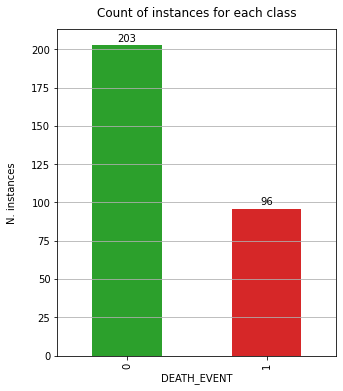

In [ ]:
xticks = [idx[0] for idx in original_df.loc[:, original_df.columns == config_dict['DATA']['TARGET_COL']].value_counts().index]
ax = original_df.loc[:, original_df.columns == config_dict['DATA']['TARGET_COL']].value_counts().plot.bar(xticks = xticks, color=class_colors, figsize=(5,6))
plt.ylabel("N. instances", labelpad=14)
plt.title("Count of instances for each class", y=1.02);
plt.grid(axis='y')
for i,p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 1, original_df.loc[:, original_df.columns == config_dict['DATA']['TARGET_COL']].value_counts().to_numpy()[i], ha="center", va="bottom")
plt.show()

### Training and test dataset splits

In [ ]:
X = original_df.loc[:, original_df.columns != config_dict['DATA']['TARGET_COL']]
y = original_df.loc[:, original_df.columns == config_dict['DATA']['TARGET_COL']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y, shuffle=True)
print(f'Training dataset length: {X_train.shape[0]}')
print(f'Test dataset length: {X_test.shape[0]}')

Training dataset length: 239
Test dataset length: 60


## Exploratory Data Analysis (EDA)

### Statistical quantitative description of features

In [ ]:
boolean_attributes = config_dict['DATA']['BOOLEAN_COLS']
numeric_attributes = config_dict['DATA']['NUMERIC_COLS']
print(display(X_train[numeric_attributes].describe()))

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,61.072527,602.790795,37.887029,263670.546444,1.391715,136.527197,127.217573
std,11.443865,1012.362885,11.994738,99410.331023,1.089060,4.425657,77.575734
min,40.000000,23.000000,15.000000,25100.000000,0.500000,113.000000,4.000000
25%,51.500000,117.000000,30.000000,212500.000000,0.900000,134.000000,69.500000
50%,60.000000,253.000000,38.000000,263358.030000,1.100000,137.000000,112.000000
75%,69.500000,582.000000,45.000000,303500.000000,1.400000,139.000000,197.500000
max,95.000000,7861.000000,80.000000,850000.000000,9.400000,148.000000,280.000000


None


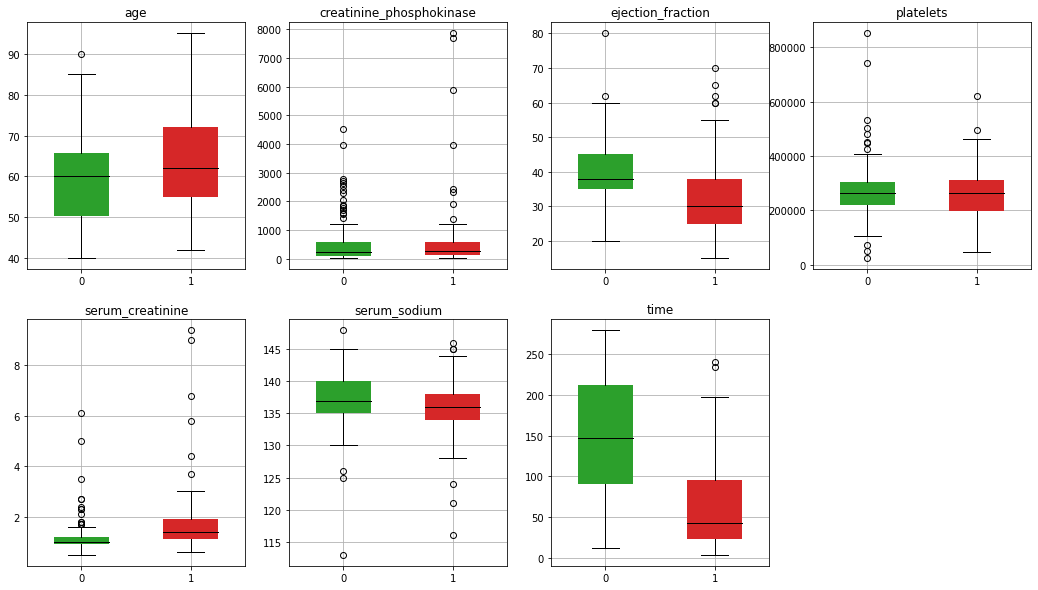

In [ ]:
def box_plot(data, labels, ax):
    bp = ax.boxplot(data, labels=labels, widths=0.5, patch_artist=True)
    for patch, color in zip(bp['boxes'], class_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('None')
    for median in bp['medians']:
        median.set_color('black')
    ax.grid()

fig1, ax1 = plt.subplots(nrows=2, ncols=4, figsize=(18,10))
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
target_col = config_dict['DATA']['TARGET_COL']
for col, ax in zip(numeric_attributes, ax1.ravel()):
    ax.set_title(f"{col}")
    per_class_df_list = [X_train[y_train[target_col]==0][col], X_train[y_train[target_col]==1][col]]
    box_plot(per_class_df_list, labels=[0,1], ax=ax)

fig1.delaxes(ax1[1][3])
fig_path = Path(boxplots_dir) / f'{col}.jpg'
fig1.savefig(fig_path, bbox_inches='tight')
plt.show()
fig1.clear()

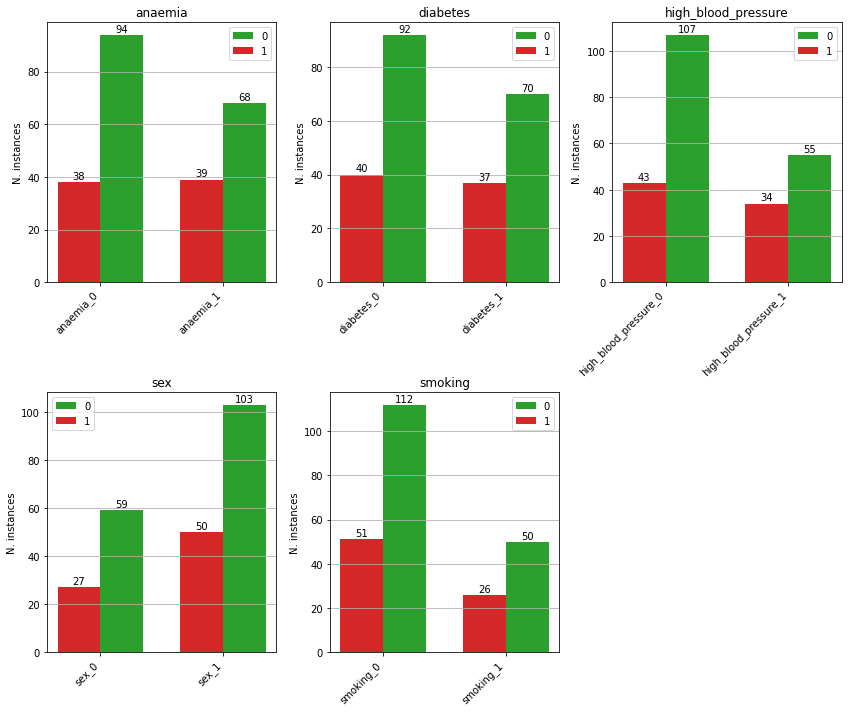

In [ ]:
fig1, ax1 = plt.subplots(nrows=2, ncols=3, figsize=(12,10))
target_col = config_dict['DATA']['TARGET_COL']

for col, ax in zip(boolean_attributes, ax1.ravel()):

    var_labels = []
    class_1_var_counts = []
    class_0_var_counts = []

    for var_value in [0,1]:
        var_labels.append(f'{col}_{var_value}')
        class_1_var_counts.append(X_train.loc[y_train[target_col]==1].loc[X_train[col]==var_value][col].count())
        class_0_var_counts.append(X_train.loc[y_train[target_col]==0].loc[X_train[col]==var_value][col].count())

    x = np.arange(len(var_labels))  # the label locations
    width = 0.35  # the width of the bars

    rects2 = ax.bar(x + width/2, class_0_var_counts, width, label='0', color=class_colors[0])
    rects1 = ax.bar(x - width/2, class_1_var_counts, width, label='1', color=class_colors[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('N. instances')
    ax.set_title(col)
    ax.set_xticks(x, var_labels, rotation=45, ha="right")
    ax.legend()
    ax.grid(axis='y')

    ax.bar_label(rects1, padding=1)
    ax.bar_label(rects2, padding=1)

fig1.tight_layout()
fig1.delaxes(ax1[1][2])
plt.show()
fig1.clear()

### Correlation analysis


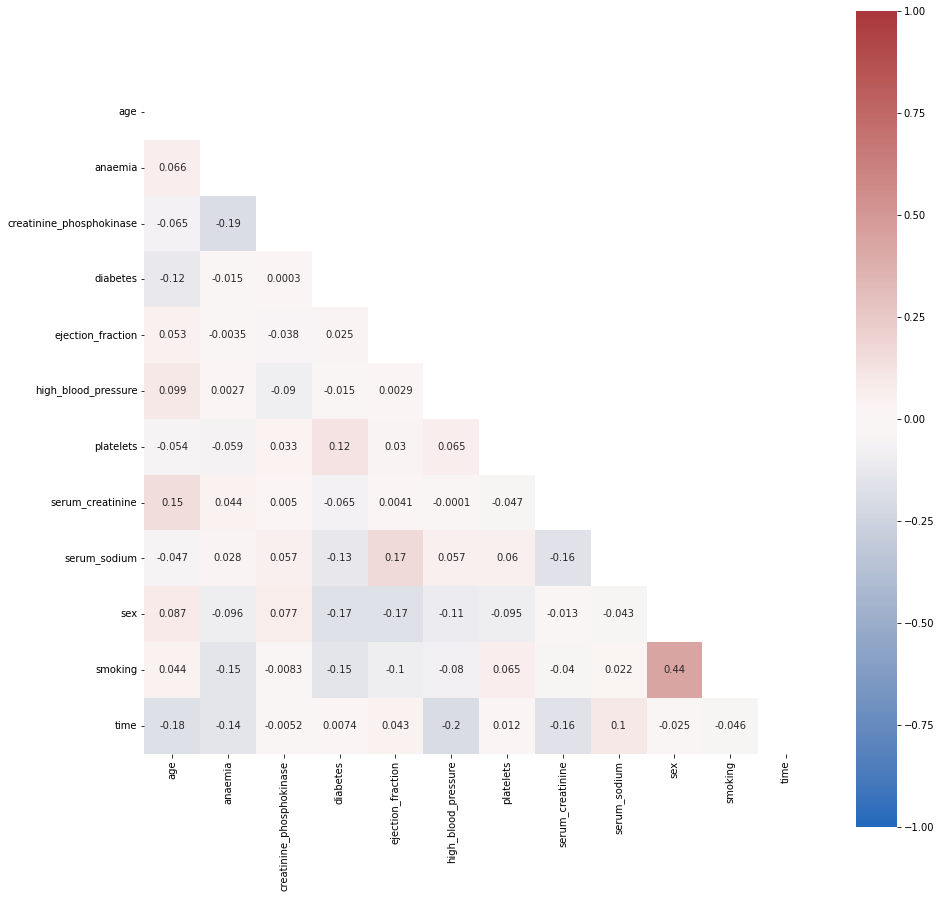

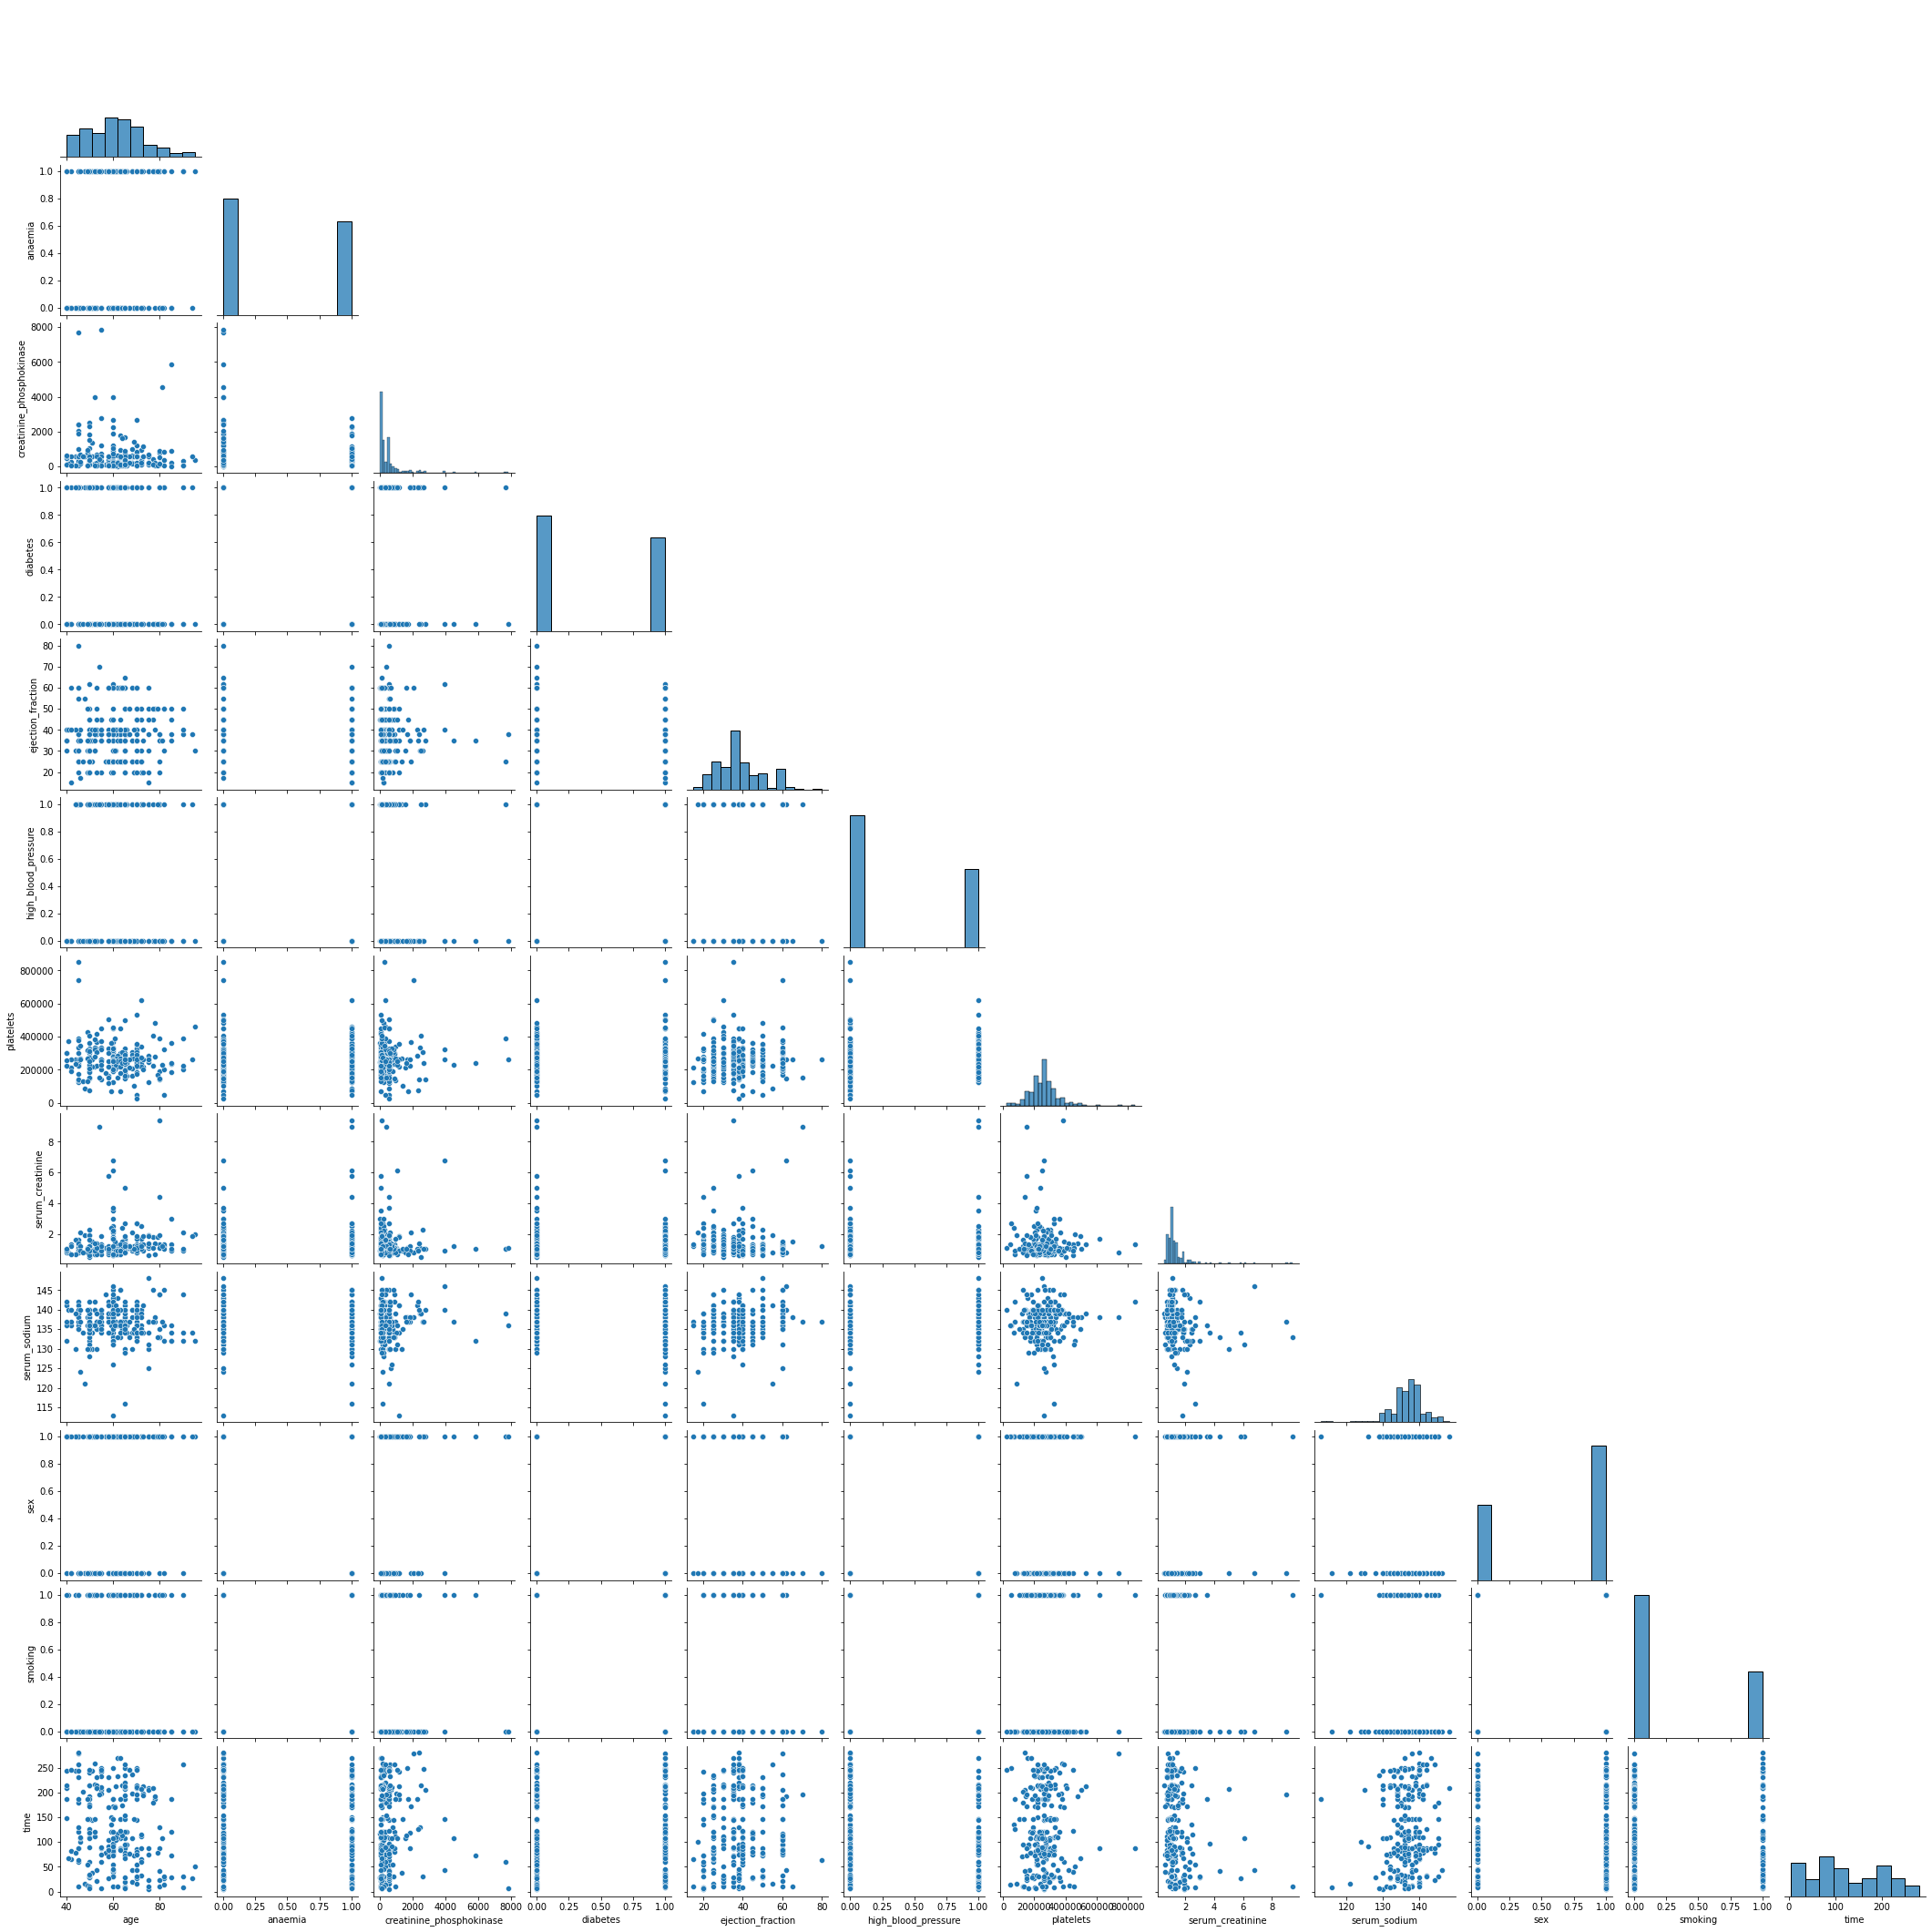

In [ ]:
corr_mat = X_train.corr()
mask_upper = np.triu(np.ones_like(corr_mat, dtype=bool))
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_mat, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask_upper, ax=ax, square=True)
sns.pairplot(X_train, corner=True)
plt.show()

## PCA

In [ ]:
def plot_PCA_explained_variance(pca, filepath):
    fig = plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative")
    plt.plot(pca.explained_variance_ratio_, label="Normal")
    plt.legend()
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance')
    fig.savefig(filepath)

def plot_PCA_biplot(pca, components, X, y, filepath):
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    fig = px.scatter(components, x=0, y=1, color=y.values.ravel(), width=700, height=500, color_continuous_scale=[[0, 'green'], [1, 'red']] )
    fig.update_yaxes(
        scaleanchor = "x",
        scaleratio = 1,
    )
    for i, feature in enumerate(X.columns):
        fig.add_shape(
            type='line',
            x0=0, y0=0,
            x1=loadings[i, 0],
            y1=loadings[i, 1]
        )
        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=feature,
        )
    fig.show()

def PCA_exp_var_analysis(X, y):
    pca = PCA(n_components=len(X.columns), random_state=config_dict['GENERAL']['RAND_STATE'])
    scaler = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ("standardscaler", StandardScaler(), numeric_attributes),
        ]
    )
    X_scaled = scaler.fit_transform(X)
    pca_components = pca.fit_transform(X_scaled)
    plot_PCA_explained_variance(pca, Path(PCA_classification_dir) / f'explained_variance.jpg')
    plot_PCA_biplot(pca, pca_components, X, y, Path(PCA_classification_dir) / f'biplot.jpg')

    first_component_eigvect = pca.components_[0]
    print(f'Eigenvector of PC0: {first_component_eigvect}')
    l = np.asarray([[X.columns[i],eig] for i, eig in enumerate(first_component_eigvect)])
    print(l)
    print(f'Features with max absolute loading in PC0: {l[np.argpartition(abs(first_component_eigvect), -3)[-3:]]}')

Eigenvector of PC0: [ 0.45277523 -0.12534681 -0.16879367 -0.20958081  0.50740041 -0.44101157
 -0.49665894  0.06018    -0.02891492  0.04586519  0.04022983  0.00843217]
[['age' '0.45277523256270585']
 ['anaemia' '-0.1253468096361361']
 ['creatinine_phosphokinase' '-0.16879366512415808']
 ['diabetes' '-0.2095808128457925']
 ['ejection_fraction' '0.5074004146507016']
 ['high_blood_pressure' '-0.44101156827846527']
 ['platelets' '-0.49665893922943105']
 ['serum_creatinine' '0.06018000003610188']
 ['serum_sodium' '-0.028914924302999967']
 ['sex' '0.04586518538076481']
 ['smoking' '0.040229834933261294']
 ['time' '0.008432166535333206']]
Features with max loading in PC0: [['age' '0.45277523256270585']
 ['platelets' '-0.49665893922943105']
 ['ejection_fraction' '0.5074004146507016']]


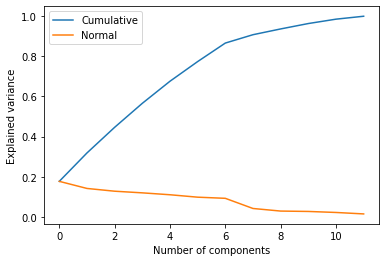

In [ ]:
PCA_exp_var_analysis(X_train, y_train)

## Classification

### Plots

In [ ]:
def print_classification_report(y, y_pred, title='Classification report:'):
    print(f"\n{title}")
    # print(metrics.classification_report(y, y_pred))
    display(pd.DataFrame.from_dict(metrics.classification_report(y, y_pred, output_dict=True)).T)

def plot_confusion_matrix(model, X, y, filepath, title='Confusion matrix'):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_title(title)
    metrics.ConfusionMatrixDisplay.from_estimator(model, X, y, ax=ax)
    fig.show()
    fig.savefig(filepath)

# def plot_PRC(precision_recall_classifiers):
#     fig_prc = plt.figure(figsize=(6,6))
#     ax = fig_prc.gca()
#     ax.set_xlim([-0.1, 1.1])
#     ax.set_ylim([-0.1, 1.1])
#     ax.grid(True)
#     ax.set_aspect('equal')
#     ax.set_title("Precision-Recall Curves")
#     for pr_data in precision_recall_classifiers:
#         ax.plot(pr_data[1], pr_data[0], label=f'{pr_data[2]} (AP={metrics.auc(pr_data[1], pr_data[0])})')
#     ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
#     fig_prc.show()
#     fig_prc.savefig(Path(classification_dir) / f'prc.jpg')

def plot_PRC(y_preds, y):
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True)
    ax.set_aspect('equal')
    ax.legend(loc='lower right')
    ax.set_title("Precision-Recall Curves")
    for y_pr in y_preds:
        metrics.PrecisionRecallDisplay.from_predictions(y, y_pr[0], name=y_pr[1], ax=ax)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    fig.show()
    # fig.savefig(filepath)

def plot_decision_boundary(X, y, classifier, noise=False, apply_PCA=False, feature_names=None):
    n_classes = 2
    labels = [f"{config_dict['DATA']['TARGET_COL']}=FALSE", f"{config_dict['DATA']['TARGET_COL']}=TRUE"]
    plot_colors = ["red", "green"]

    plot_step = 0.02

    fig = plt.figure(figsize=(10,7))

    # # X = X[:,:3]
    # x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    # y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # plt.figure(2, figsize=(8, 6))
    # plt.clf()

    # # Plot the training points
    # plt.scatter(X[:, 0], X[:, 1], c=y.values.ravel(), cmap=plt.cm.Set1, edgecolor="k")

    # plt.xlim(x_min, x_max)
    # plt.ylim(y_min, y_max)
    # plt.xticks(())
    # plt.yticks(())

    # # To getter a better understanding of interaction of the dimensions
    # # plot the first three PCA dimensions
    # fig = plt.figure(1, figsize=(8, 6))
    # ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)


    # ax.scatter(
    #     X[:, 0],
    #     X[:, 1],
    #     X[:, 2],
    #     c=y.values.ravel(),
    #     cmap=plt.cm.Set1,
    #     edgecolor="k",
    # )

    # ax.set_title("First three PCA directions")
    # ax.set_xlabel("1st eigenvector")
    # ax.w_xaxis.set_ticklabels([])
    # ax.set_ylabel("2nd eigenvector")
    # ax.w_yaxis.set_ticklabels([])
    # ax.set_zlabel("3rd eigenvector")
    # ax.w_zaxis.set_ticklabels([])

    # plt.show()

    for pairidx, pair in enumerate(list(itertools.combinations(range(X.shape[1]),2))):
        _X = X[:, list(pair)]
        clf = classifier.fit(_X, y)
        selected_features = pair

        # Plot the decision boundary
        plt.subplot(2, 3, pairidx + 1)
        
        x_min, x_max = _X[:, 0].min() - 1, _X[:, 0].max() + 1
        y_min, y_max = _X[:, 1].min() - 1, _X[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        Z[0,0]=1 #prevent the color map to collapse when the model did overfit
        cs = plt.contourf(xx, yy, Z, cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) )

        if apply_PCA:
            plt.xlabel(f'PC{selected_features[0]}')
            plt.ylabel(f'PC{selected_features[1]}')
        else:
            plt.xlabel(f'{feature_names[selected_features[0]]}')
            plt.ylabel(f'{feature_names[selected_features[1]]}')

        # Plot the training points
        if noise:
            _noise = np.random.normal(0, .05, _X.shape)
            _X = _X + _noise
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(
                _X[idx, 0],
                _X[idx, 1],
                c=color,
                label=labels[i],
                cmap=plt.cm.RdYlBu,
                edgecolor="black",
                s=15,
            )


    plt.suptitle(f"Decision boundary of {type(classifier).__name__}{' + PCA' if apply_PCA else ''}")
    # plt.legend(loc="lower right", borderpad=0, handletextpad=0)
    plt.axis("tight")
    plt.show()

def plot_classifier_specific_graphs(name, trained_model, X, y, y_pred, y_pred_proba, feature_scaler):
    if name == 'LogisticRegression':
        plt.figure()
        feature = [i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f=="ejection_fraction"][0]
        m = trained_model.coef_[0,feature]
        b = trained_model.intercept_[0]
        x_v = X[:,feature]
        max_x_v = max(x_v)
        min_x_v = min(x_v)
        x_v = x_v * (max_x_v-min_x_v) + min_x_v
        rescale_factor = max_x_v-min_x_v
        #generate values for curve overlay
        lgs_curve = lambda x: 1/(1 + math.e**((int(max_x_v)+10)*(m*(x-rescale_factor)+b)))         
        x_values = np.linspace(int(min_x_v)-10, int(max_x_v)+10, int(max_x_v)+10)
        y_values = lgs_curve(x_values)

        # x_labels = 
        # y_label = config_dict['DATA']['TARGET_COL']

        #plot it
        
        print(x_v.shape)
        print(y.values.ravel().shape)

        plt.plot(x_values, y_values)
        plt.scatter(x_v, y.values.ravel(), c='r', s=2)
        plt.xlabel("Ejection fraction")
        plt.ylabel("Probability of Death event")

        # plt.figure()
        # #generate values for curve overlay
        # feature = [i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f=="ejection_fraction"][0]
        # rescale_factor = 87-21
        # m = trained_model.coef_[0,feature]
        # b = trained_model.intercept_[0]
        # lgs_curve = lambda x: 1/(1 + math.e**(100*(m*(x-rescale_factor)+b)))         
        # x_values = np.linspace(0, 100, 100)
        # y_values = lgs_curve(x_values)
        # plt.plot(x_values, y_values)
        # plt.scatter(X[:,feature].ravel(),y_pred_proba[:,1], c='r', s=2)
        # sns.regplot(x="ejection_fraction", y=config_dict['DATA']['TARGET_COL'], data=X, logistic=True)
        # plt.xlabel("Ejection fraction")
        # plt.ylabel("Probability of Death event")

    if name == "DecisionTree":
        plt.figure(figsize=(15,10))
        tree.plot_tree(trained_model, fontsize=10, feature_names=feature_scaler.get_feature_names_out(), class_names=[f"{config_dict['DATA']['TARGET_COL']}=False", f"{config_dict['DATA']['TARGET_COL']}=True"], label='all', filled=True, rounded=True, max_depth=trained_model.get_depth())
        plt.show()

### The cross-validation process

In [325]:
class ClassificationProcessor():

    def __init__(self, classifiers):
        self.__best_classifier = None
        self.__classifiers = classifiers
        self.__y_preds = []

    def find_best_model(self, X_train, y_train, apply_PCA=False, n_components=None):
        best_classifier = None
        best_score = 0

        for classifier in self.__classifiers:
            if apply_PCA and classifier.name in ["DecisionTree", "RandomForest"]:
                continue
            global_test_score, global_test_std = classifier.nested_CV(X_train, y_train, apply_PCA, n_components=n_components)
            if global_test_score > best_score:
                best_score = global_test_score
                best_classifier = classifier
                
        self.__best_classifier = best_classifier
        print(f'\nBEST CLASSIFIER: {self.__best_classifier.name} (F1-score={best_score})')

        
    def __models_fit_predict(self, X_train, y_train, X_test, y_test, compare_all_classifiers=False, apply_PCA=False, n_components=None):
        # simple cross validation to train the best model:
        print('>> Simple cross validation to train the best model...')

        if compare_all_classifiers:
            list_classifiers = self.__classifiers
        else:
            list_classifiers = [self.__best_classifier]

        if apply_PCA:
            pca = PCA(n_components=n_components, random_state=config_dict['GENERAL']['RAND_STATE'])
            scaler = ColumnTransformer(
                remainder='passthrough',
                transformers=[
                    ("standardscaler", StandardScaler(), numeric_attributes),
                ]
            )
            X_scaled = scaler.fit_transform(X_train)
            pca.fit(X_scaled)
            print(f'Cumulative explained variance for {pca.n_components_} principal components: {np.sum(pca.explained_variance_ratio_)}')


        cv = StratifiedKFold(n_splits=config_dict['CROSSVAL']['K_INNER'], shuffle=True, random_state=config_dict['GENERAL']['RAND_STATE'])

        for classifier in list_classifiers:
            if apply_PCA and classifier.name in ["DecisionTree", "RandomForest"]:
                continue
            #precision, recall, name = classifier.simple_CV(cv, X_train, y_train, X_test, y_test, apply_PCA=apply_PCA, n_components=n_components)
            #self.precision_recall_classifiers.append([precision, recall, name])
            self.__y_preds.append(classifier.simple_CV(cv, X_train, y_train, X_test, y_test, apply_PCA=apply_PCA, n_components=n_components))
    
    def test_best_model(self, X_train, y_train, X_test, y_test, apply_PCA):
        self.__models_fit_predict(X_train, y_train, X_test, y_test, compare_all_classifiers=False, apply_PCA=apply_PCA, n_components=None)

    def compare_models(self, X_train, y_train, X_test, y_test, apply_PCA,n_components=None):
        self.__models_fit_predict(X_train, y_train, X_test, y_test, compare_all_classifiers=True, apply_PCA=apply_PCA, n_components=n_components)

    def plot_PRC(self, y):
        # plot_PRC(self.precision_recall_classifiers)
        plot_PRC(self.__y_preds, y)


class Classifier():

    def __init__(self, name, model, grid, class_balancer, feature_scaler):
        self.name = name
        self.model = model
        self.grid = grid
        self.class_balancer = class_balancer
        self.feature_scaler = feature_scaler
        
        self.pipeline = Pipeline([
            ('feature_scaler', feature_scaler), 
            ('classbalancer', self.class_balancer), 
            (self.name, self.model)])


    def nested_CV(self, X_train, y_train, apply_PCA=False, n_components=None):
        test_outer_results = []
        train_outer_results = []
        best_hyperparams = []
        
        pipeline = None
        if apply_PCA:
            pipeline = Pipeline([
                ('feature_scaler', self.feature_scaler), 
                ('classbalancer', self.class_balancer),
                ('pca', PCA(n_components=n_components, random_state=config_dict['GENERAL']['RAND_STATE'])), 
                (self.name, self.model)
                ])
        else:
            pipeline = self.pipeline

        cv_outer = StratifiedKFold(n_splits=config_dict['CROSSVAL']['K_OUTER'], shuffle=True, random_state=config_dict['GENERAL']['RAND_STATE'])

        # nested cross validation for unbiased error estimation:
        print("\n===================================================================")
        print(f"\t\t\t{self.name} {'+ PCA' if apply_PCA else ''}")
        print("===================================================================\n")
        print(">> Nested cross validation for unbiased error estimation...")
        for train_ix, test_ix in cv_outer.split(X_train, y_train):

            # split data in k_outer folds (one is test, the rest is trainval) for outer loop
            X_train_cv, X_test_cv = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
            y_train_cv, y_test_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]

            # inner cross validation procedure for grid search of best hyperparameters:
            # trainval will be split in k_inner folds (one is val, the rest is train)
            # use train and val to find best model
            cv_inner = StratifiedKFold(n_splits=config_dict['CROSSVAL']['K_INNER'], shuffle=True,
                                random_state=config_dict['GENERAL']['RAND_STATE'])
            # search = RandomizedSearchCV(estimator=self.pipeline, param_distributions=self.grid, n_iter=20, cv=cv_inner, n_jobs=-1,
            #                         scoring='f1', refit=True, verbose=2)
            search = GridSearchCV(estimator=pipeline, param_grid=self.grid, cv=cv_inner, n_jobs=-1,
                                    scoring='f1', refit=True, verbose=0)

            # outer cross validation procedure to evaluate the performance of the best estimator:
            # fit the best model on the whole trainval
            search.fit(X_train_cv, y_train_cv.values.ravel())
            best_model = search.best_estimator_
            best_score = search.best_score_
            best_param = search.best_params_

            # evaluate the performance of the model on test
            y_test_pred = search.predict(X_test_cv)
            test_score = metrics.f1_score(y_test_cv, y_test_pred)
            y_train_pred = search.predict(X_train_cv)
            train_score = metrics.f1_score(y_train_cv, y_train_pred)

            test_outer_results.append(test_score)
            train_outer_results.append(train_score)
            best_hyperparams.append(search.best_params_)

            print('\n__________________________________________________________\n')
            print(f"Inner CV: ")
            print(f"    Best F1-score = {best_score}")
            print(f"Outer CV: ")
            print(f"    Val F1-score = {test_score}")
            # print_classification_report(y_test_cv, y_test_pred, "Outer CV Val classification report")
            # print_classification_report(y_train_cv, y_train_pred, "Outer CV Train classification report")

        # calculate the mean score over all K outer folds, and report as the generalization error
        global_test_score = np.mean(test_outer_results)
        global_test_std = np.std(test_outer_results)
        global_train_score = np.mean(train_outer_results)
        global_train_std = np.std(train_outer_results)

        print('\n__________________________________________________________\n')
        print(f"Mean training F1-score = {str(global_train_score)} ({str(global_train_std)})")
        print(f"Mean validation F1-score = {str(global_test_score)} ({str(global_test_std)})")
        print("List of best hyperparameters to check stability: ")
        best_hyperparams_dict = {}
        for best_hyps in best_hyperparams:
            for k,v in best_hyps.items():
                if k not in best_hyperparams_dict:
                    best_hyperparams_dict[k] = [v]
                else:
                    best_hyperparams_dict[k].append(v)
        print(display(pd.DataFrame.from_dict(best_hyperparams_dict)))

        return global_test_score, global_test_std


    def simple_CV(self, cv, X_train, y_train, X_test, y_test, apply_PCA=False, n_components=None):

        print("\n===================================================================")
        print(f"\t\t\t{self.name} {'+ PCA' if apply_PCA else ''}")
        print("===================================================================\n")

        pipeline = None
        if apply_PCA and self.name not in ["DecisionTree", "RandomForest"]:
            pipeline = Pipeline([
                ('feature_scaler', self.feature_scaler), 
                ('classbalancer', self.class_balancer),
                ('pca', PCA(n_components=n_components, random_state=config_dict['GENERAL']['RAND_STATE'])), 
                (self.name, self.model)
                ])
        else:
            pipeline = self.pipeline

        # search = RandomizedSearchCV(estimator=self.pipeline, param_distributions=self.grid, n_iter=20, cv=cv, n_jobs=-1,
        #                 scoring='f1', refit=True, verbose=2) 

        search = GridSearchCV(estimator=pipeline, param_grid=self.grid, cv=cv, n_jobs=-1,
                                scoring='f1', refit=True, verbose=0)

        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_hyperparam = search.best_params_
        best_score = search.best_score_

        print('Best hyperparameters:')
        print(display(pd.DataFrame(best_hyperparam, index=[0])))
        print()

        print('>> Predicting on test dataset...')
        y_pred = search.predict(X_test)
        print_classification_report(y_test, y_pred, "Test classification report")

        # prc_display = metrics.PrecisionRecallDisplay.from_predictions(y_test, y_pred)
        # prc_display = prc_display.plot(ax=prc_ax, name=self.name)

        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)

        # plot confusion matrix
        plot_confusion_matrix(best_model, X_test, y_test, Path(confusion_matr_dir) / f"confusion_matrix_{self.name}{'_PCA' if apply_PCA else ''}.jpg", f"Confusion matrix with {self.name}{' + PCA' if apply_PCA else ''}")

        X_test_scaled = best_model.named_steps['feature_scaler'].transform(X_test)
        if self.name == 'LogisticRegression' or self.name == "DecisionTree":
            y_pred_proba = search.predict_proba(X_test)
            plot_classifier_specific_graphs(self.name, best_model.named_steps[self.name], X_test_scaled, y_test, y_pred, y_pred_proba, best_model.named_steps['feature_scaler'])

        if apply_PCA and self.name not in ["DecisionTree", "RandomForest"]:
            # first_components = search.best_estimator_.named_steps['pca'].components_[:3]
            X_test_pca = best_model.named_steps['pca'].transform(X_test_scaled)[:, :3]
            plot_decision_boundary(X_test_pca, y_test, best_model.named_steps[self.name], apply_PCA=apply_PCA)
        else:
            feature_idxs_names = np.asarray([[i, f] for i, f in enumerate(best_model.named_steps['feature_scaler'].get_feature_names_out()) if f=="ejection_fraction" or f=="serum_creatinine" or f=="time"])
            X_test_scaled_filtered_columns = X_test_scaled[:,feature_idxs_names[:, 0].astype(int)]
            plot_decision_boundary(X_test_scaled_filtered_columns, y_test, best_model.named_steps[self.name], feature_names=feature_idxs_names[:, 1])

        #return precision, recall, self.name
        return [y_pred, self.name]



    


### Nested CV Results

In [329]:
# Standardizing features by removing the mean and scaling to unit variance:
# z = (x - u) / s
feature_scaler = config_dict['CLASSIFICATION']['SCALERS']['StandardScaler']
# class rebalancing
feature_scaler1 = clone(feature_scaler)
_ = feature_scaler1.fit_transform(X_train) # done just to retreive the categorical features indices (modified by the scaler)
class_balancer = config_dict['CLASSIFICATION']['BALANCERS']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['DATA']['BOOLEAN_COLS']])

classifiers = []

for classifier_name, classifier_model in config_dict['CLASSIFICATION']['MODELS'].items():
    # if classifier_name == "RandomForest":
    classifiers.append(Classifier(classifier_name, classifier_model, config_dict['CLASSIFICATION']['PARAMS'][classifier_name], class_balancer, feature_scaler))

clf_processor = ClassificationProcessor(classifiers)
# clf_processor.find_best_model(X_train, y_train, apply_PCA=config_dict['CLASSIFICATION']['APPLY_PCA'], n_components=config_dict['CLASSIFICATION']['N_COMPONENTS_PCA'])
clf_processor.find_best_model(X_train, y_train, apply_PCA=False, n_components=None)
# clf_processor.find_best_model(X_train, y_train, apply_PCA=True, n_components=config_dict['CLASSIFICATION']['N_COMPONENTS_PCA'])


			SVC 

>> Nested cross validation for unbiased error estimation...

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7716116300823949
Outer CV: 
    Val F1-score = 0.588235294117647

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7534522485301128
Outer CV: 
    Val F1-score = 0.5714285714285714

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7402294289363255
Outer CV: 
    Val F1-score = 0.75

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7319158491572285
Outer CV: 
    Val F1-score = 0.7000000000000001

__________________________________________________________

Inner CV: 
    Best F1-score = 0.724397397668745
Outer CV: 
    Val F1-score = 0.75

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7455826008564345
Outer CV: 
    Val F1-score = 0.7368421052631579


,SVC__C,SVC__gamma,SVC__kernel,SVC__random_state
0,0.001,0.010,rbf,42
1,0.100,0.001,linear,42
2,100.000,0.001,rbf,42
3,0.001,0.010,rbf,42
4,10.000,0.010,rbf,42
5,0.001,0.010,rbf,42
6,1.000,0.100,rbf,42
7,1.000,0.001,rbf,42
8,0.010,0.001,linear,42
9,100.000,0.001,rbf,42


None

			KNN 

>> Nested cross validation for unbiased error estimation...

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7204812428950361
Outer CV: 
    Val F1-score = 0.5

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7178357963875206
Outer CV: 
    Val F1-score = 0.6250000000000001

__________________________________________________________

Inner CV: 
    Best F1-score = 0.6938138957816375
Outer CV: 
    Val F1-score = 0.625

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7138129403040415
Outer CV: 
    Val F1-score = 0.8421052631578948

__________________________________________________________

Inner CV: 
    Best F1-score = 0.6943890189506887
Outer CV: 
    Val F1-score = 0.7142857142857143

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7007201652629906
Outer CV: 
    Val F1-score = 0.625

_____

,KNN__n_jobs,KNN__n_neighbors,KNN__weights
0,-1,33,uniform
1,-1,21,uniform
2,-1,33,uniform
3,-1,33,uniform
4,-1,25,uniform
5,-1,29,uniform
6,-1,29,distance
7,-1,33,distance
8,-1,25,distance
9,-1,33,uniform


None

			LogisticRegression 

>> Nested cross validation for unbiased error estimation...

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7482077175697865
Outer CV: 
    Val F1-score = 0.588235294117647

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7348665183537264
Outer CV: 
    Val F1-score = 0.6666666666666666

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7214464674758793
Outer CV: 
    Val F1-score = 0.7058823529411765

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7220432959698811
Outer CV: 
    Val F1-score = 0.6666666666666667

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7035556712976068
Outer CV: 
    Val F1-score = 0.75

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7159047619047618
Outer CV: 
   

,LogisticRegression__C,LogisticRegression__max_iter,LogisticRegression__penalty,LogisticRegression__random_state,LogisticRegression__solver
0,1.0,1000,l1,42,liblinear
1,0.1,1000,l2,42,liblinear
2,0.1,1000,l2,42,liblinear
3,10.0,1000,l2,42,liblinear
4,0.1,1000,l2,42,liblinear
5,10.0,1000,l1,42,liblinear
6,1.0,1000,l2,42,liblinear
7,10.0,1000,l1,42,liblinear
8,0.1,1000,l2,42,liblinear
9,0.1,1000,l2,42,liblinear


None

			DecisionTree 

>> Nested cross validation for unbiased error estimation...

__________________________________________________________

Inner CV: 
    Best F1-score = 0.6982147359499974
Outer CV: 
    Val F1-score = 0.6250000000000001

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7197132616487456
Outer CV: 
    Val F1-score = 0.7692307692307692

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7425912403275486
Outer CV: 
    Val F1-score = 0.625

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7583900836320192
Outer CV: 
    Val F1-score = 0.823529411764706

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7282988007845693
Outer CV: 
    Val F1-score = 0.75

__________________________________________________________

Inner CV: 
    Best F1-score = 0.710486078005544
Outer CV: 
    Val F1-score = 0.75

,DecisionTree__criterion,DecisionTree__max_depth,DecisionTree__min_samples_split,DecisionTree__random_state
0,entropy,4,2,42
1,gini,4,2,42
2,gini,3,2,42
3,gini,2,2,42
4,gini,2,2,42
5,entropy,2,2,42
6,entropy,7,5,42
7,entropy,2,2,42
8,gini,2,2,42
9,entropy,3,2,42


None

			RandomForest 

>> Nested cross validation for unbiased error estimation...

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7794660734149055
Outer CV: 
    Val F1-score = 0.7368421052631579

__________________________________________________________

Inner CV: 
    Best F1-score = 0.8077402513442559
Outer CV: 
    Val F1-score = 0.75

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7987267904509284
Outer CV: 
    Val F1-score = 0.625

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7863401912489134
Outer CV: 
    Val F1-score = 0.7058823529411765

__________________________________________________________

Inner CV: 
    Best F1-score = 0.7957966764418378
Outer CV: 
    Val F1-score = 0.7142857142857143

__________________________________________________________

Inner CV: 
    Best F1-score = 0.782985347985348
Outer CV: 
    Val F1-score = 0.8

,RandomForest__criterion,RandomForest__max_depth,RandomForest__max_features,RandomForest__min_samples_split,RandomForest__n_estimators,RandomForest__n_jobs,RandomForest__random_state
0,gini,4,sqrt,2,10,-1,42
1,gini,3,sqrt,10,10,-1,42
2,entropy,5,sqrt,2,100,-1,42
3,entropy,2,sqrt,2,10,-1,42
4,entropy,6,sqrt,10,100,-1,42
5,gini,7,sqrt,2,100,-1,42
6,entropy,4,sqrt,5,10,-1,42
7,gini,8,sqrt,5,10,-1,42
8,gini,8,sqrt,5,100,-1,42
9,gini,4,sqrt,2,100,-1,42


None

BEST CLASSIFIER: RandomForest (F1-score=0.7564330793045964)


### Comparison of classifiers on test dataset

>> Simple cross validation to train the best model...

			SVC 

Best hyperparameters:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,SVC__C,SVC__gamma,SVC__kernel,SVC__random_state
0,0.1,0.01,rbf,42


None

>> Predicting on test dataset...

Test classification report


,precision,recall,f1-score,support
0,0.844444,0.926829,0.883721,41.000000
1,0.800000,0.631579,0.705882,19.000000
accuracy,0.833333,0.833333,0.833333,0.833333
macro avg,0.822222,0.779204,0.794802,60.000000
weighted avg,0.830370,0.833333,0.827405,60.000000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



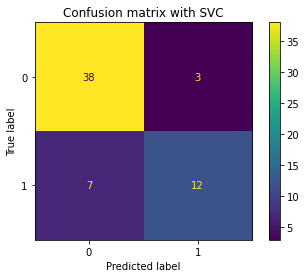

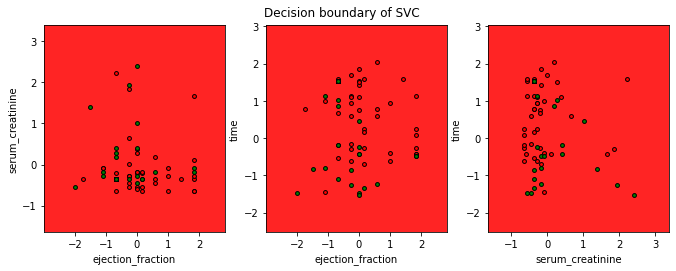


			KNN 

Best hyperparameters:


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



,KNN__n_jobs,KNN__n_neighbors,KNN__weights
0,-1,33,distance


None

>> Predicting on test dataset...

Test classification report


,precision,recall,f1-score,support
0,0.790698,0.829268,0.809524,41.000000
1,0.588235,0.526316,0.555556,19.000000
accuracy,0.733333,0.733333,0.733333,0.733333
macro avg,0.689466,0.677792,0.682540,60.000000
weighted avg,0.726585,0.733333,0.729101,60.000000


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



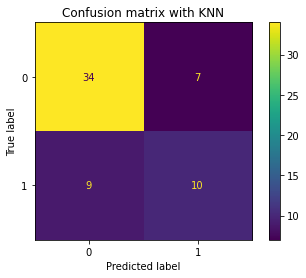

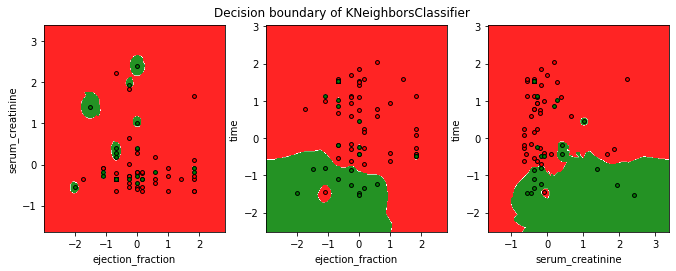


			LogisticRegression 

Best hyperparameters:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,LogisticRegression__C,LogisticRegression__max_iter,LogisticRegression__penalty,LogisticRegression__random_state,LogisticRegression__solver
0,1,1000,l1,42,liblinear


None

>> Predicting on test dataset...

Test classification report


,precision,recall,f1-score,support
0,0.822222,0.902439,0.860465,41.0
1,0.733333,0.578947,0.647059,19.0
accuracy,0.800000,0.800000,0.800000,0.8
macro avg,0.777778,0.740693,0.753762,60.0
weighted avg,0.794074,0.800000,0.792886,60.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



(60,)
(60,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



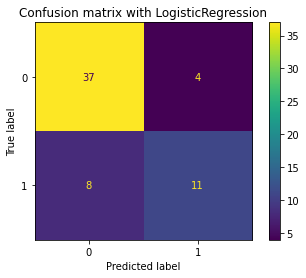

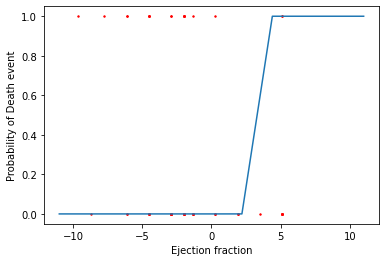

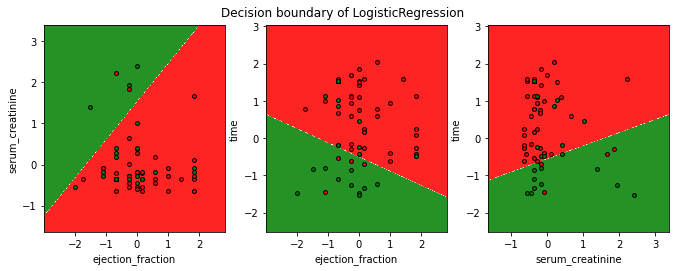


			DecisionTree 

Best hyperparameters:


,DecisionTree__criterion,DecisionTree__max_depth,DecisionTree__min_samples_split,DecisionTree__random_state
0,entropy,2,2,42


None

>> Predicting on test dataset...

Test classification report


,precision,recall,f1-score,support
0,0.888889,0.780488,0.831169,41.000000
1,0.625000,0.789474,0.697674,19.000000
accuracy,0.783333,0.783333,0.783333,0.783333
macro avg,0.756944,0.784981,0.764422,60.000000
weighted avg,0.805324,0.783333,0.788896,60.000000


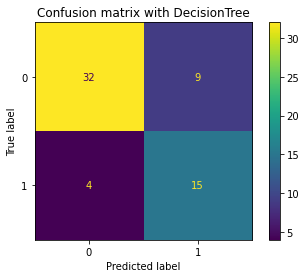

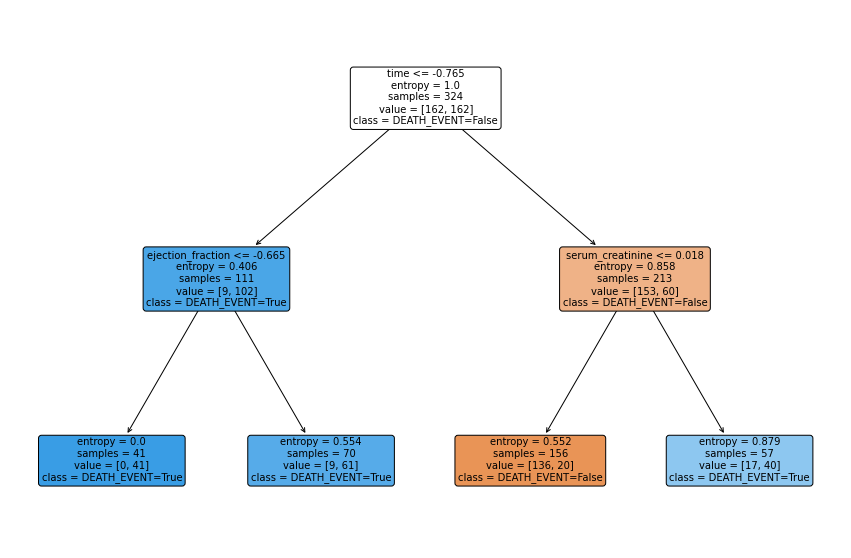

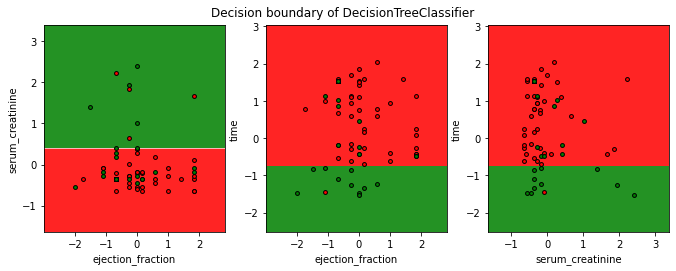


			RandomForest 

Best hyperparameters:


/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



,RandomForest__criterion,RandomForest__max_depth,RandomForest__max_features,RandomForest__min_samples_split,RandomForest__n_estimators,RandomForest__n_jobs,RandomForest__random_state
0,gini,3,sqrt,10,10,-1,42


None

>> Predicting on test dataset...

Test classification report


,precision,recall,f1-score,support
0,0.875000,0.853659,0.864198,41.000000
1,0.700000,0.736842,0.717949,19.000000
accuracy,0.816667,0.816667,0.816667,0.816667
macro avg,0.787500,0.795250,0.791073,60.000000
weighted avg,0.819583,0.816667,0.817885,60.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



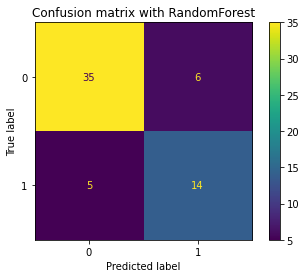

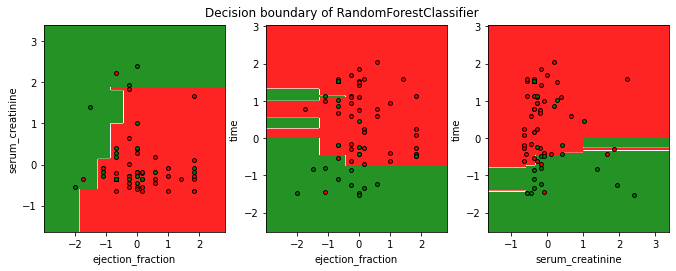

In [330]:
# clf_processor.compare_models(X_train, y_train, X_test, y_test, apply_PCA=config_dict['CLASSIFICATION']['APPLY_PCA'], n_components=config_dict['CLASSIFICATION']['N_COMPONENTS_PCA'])
clf_processor.compare_models(X_train, y_train, X_test, y_test, apply_PCA=False, n_components=None)
# clf_processor.compare_models(X_train, y_train, X_test, y_test, apply_PCA=True, n_components=config_dict['CLASSIFICATION']['N_COMPONENTS_PCA'])



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


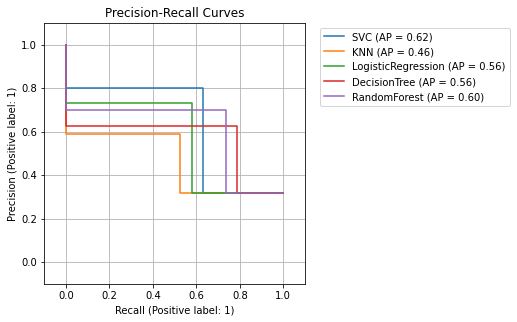

In [331]:
clf_processor.plot_PRC(y_test)

## SMOTE-NC visualization

In [ ]:
def plot_resampling(X, y, sampler, ax, title=None, ax_labels=None):
    features_to_display_idx = [i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in features_to_display]
    X_res, y_res = sampler.fit_resample(X, y)
    X_res = X_res[:,features_to_display_idx]
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res.values.ravel(), alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    if ax_labels is not None:
        ax.set_xlabel(ax_labels[0])
        ax.set_ylabel(ax_labels[1])
    sns.despine(ax=ax, offset=10)

def compare_rebalancing_techniques(samplers, X, y, ax_labels=None):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    for ax, sampler in zip(axs.ravel(), samplers):
        title = "Original dataset" if isinstance(sampler, FunctionSampler) else None
        plot_resampling(X, y, sampler, ax, title=title, ax_labels=ax_labels)
    fig.tight_layout()

In [ ]:
feature_scaler.set_params(verbose_feature_names_out=False)
X_train_scaled = feature_scaler.fit_transform(X_train)

# visualize augmentation in a pair plot with a categorical feature
features_to_display_idx = [i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in ['platelets', 'creatinine_phosphokinase']]
features_to_display = feature_scaler.get_feature_names_out()[features_to_display_idx]
samplers = [
    FunctionSampler(), # no rebalancing
    # RandomOverSampler(random_state=0),
    config_dict['CLASSIFICATION']['BALANCERS']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in config_dict['DATA']['BOOLEAN_COLS']]),
]
compare_rebalancing_techniques(samplers, X_train_scaled, y_train, ax_labels=features_to_display)

# visualize augmentation in a pair plot with two numeric features
features_to_display_idx = [i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in ['diabetes', 'serum_creatinine']]
features_to_display = feature_scaler.get_feature_names_out()[features_to_display_idx]
samplers = [
    FunctionSampler(), # no rebalancing
    # RandomOverSampler(random_state=0),
    config_dict['CLASSIFICATION']['BALANCERS']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in config_dict['DATA']['BOOLEAN_COLS']]),
]
compare_rebalancing_techniques(samplers, X_train_scaled, y_train, ax_labels=features_to_display)

In [ ]:
feature_scaler.get_feature_names_out()